In [9]:
import math
from data_loader import Data_loader
from pair_filter import NPD_filter
from pair_filter import OLS_filter
import matplotlib.pyplot as plt
from backtest import PairTradingBacktester_TrainTest
from optimizers import MRP_optimizer_scipy
import pandas as pd
from backtest_MRP import backtest_MRP

num_month_train = 8
num_month_test = 2

dl = Data_loader(num_month_train=num_month_train, num_month_test=num_month_test)

window_train, window_test = dl.get_window(start_idx=200)

In [10]:
# def pipeline_MRP(window_train, window_test):

## 1. Pair selection phase
# NPD selection
NPD = NPD_filter(window_train)
pairs, distance = NPD.select_pairs(percentile=5, verbose=False)


# OLS selection
OLS = OLS_filter(window_train)
pairs, params = OLS.select_pairs(pairs, verbose=False, confidence_level=0.01)


# backtest and select top k pairs with top sharpe ratio on train data
top_k = 50

# bt = PairTradingBacktester_TrainTest(pairs[:300], params[:300], window_train, window_test) # for testing purpose
bt = PairTradingBacktester_TrainTest(pairs, params, window_train, window_test) # complete
_ = bt.run(top_k=top_k)
spreads_train  = bt.train_spreads_df
# spreads_test  = bt.test_spreads_df
# returns_test   = bt.test_returns_df
# returns_train   = bt.train_returns_df
comp_weights=bt.comp_weights

## 2. Apply MRP optimizer to generate weights a mean-reverting portfolio 
optimal_weights=MRP_optimizer_scipy(spreads_data=spreads_train)
weights_by_levels=pd.concat([comp_weights.reset_index(level=1),optimal_weights],axis=1) # different levels of weights, combined by pair index

weights_by_levels['flat_w']=weights_by_levels['component_w']*weights_by_levels['opt_w']
weights_single_stocks=weights_by_levels.groupby('stock')['flat_w'].sum()


##  3. Run backtest using the optimized weights
bt_MRP = backtest_MRP(weights_single_stocks, window_train, window_test)
table_train, table_test = bt_MRP.run()

    # return (table_train, table_test)

`gtol` termination condition is satisfied.
Number of iterations: 4595, function evaluations: 4993, CG iterations: 11213, optimality: 9.06e-09, constraint violation: 2.86e-11, execution time:  2.4 s.


In [14]:
table_train

,portfolio_value,residuals,threshold,trade_signal,unwind_signal,position,cum_ret
date,,,,,,,
1990-10-16,-1.073130,1.021951,0.427271,-1,0,-1.0,1.000000e+00
1990-10-17,-2.207116,-0.112035,0.427271,0,1,0.0,2.056709e+00
1990-10-18,-2.571993,-0.476912,0.427271,1,0,1.0,2.056709e+00
1990-10-19,-2.394234,-0.299152,0.427271,0,0,1.0,2.198856e+00
1990-10-22,-2.167120,-0.072039,0.427271,0,0,1.0,2.407436e+00
...,...,...,...,...,...,...,...
1991-06-07,-2.654120,-0.559039,0.427271,1,1,1.0,7.933277e+08
1991-06-10,-1.619107,0.475974,0.427271,-1,1,0.0,1.102697e+09
1991-06-11,-2.263509,-0.168428,0.427271,0,1,0.0,1.102697e+09


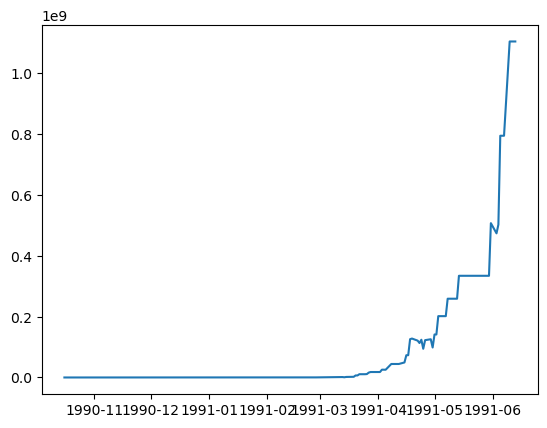

In [15]:
plt.plot(table_train['cum_ret'])

In [16]:
table_test

,portfolio_value,residuals,threshold,trade_signal,unwind_signal,position,cum_ret
date,,,,,,,
1991-06-14,-2.030062,0.065019,0.427271,0,0,0.0,1.000000
1991-06-17,-1.549677,0.545405,0.427271,-1,0,-1.0,1.000000
1991-06-18,-2.064497,0.030585,0.427271,0,0,-1.0,1.332211
1991-06-19,-1.978730,0.116351,0.427271,0,0,-1.0,1.276866
1991-06-20,-0.912966,1.182116,0.427271,-1,0,-1.0,0.589133
1991-06-21,-2.094504,0.000577,0.427271,0,0,-1.0,1.351575
1991-06-24,-1.804369,0.290712,0.427271,0,0,-1.0,1.164352
1991-06-25,-2.100013,-0.004932,0.427271,0,1,0.0,1.355130
1991-06-26,-1.252183,0.842899,0.427271,-1,1,-1.0,1.355130
